In [2]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import MultiViewMultiLabelMetaDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np



# train and test functions
from src.train import multitask_pretrain
from src.test import test_multitask
import random 
import pandas as pd

In [3]:
def set_random_seeds(seed):
    random.seed(seed)          # Python random module
    np.random.seed(seed)       # NumPy random module
    torch.manual_seed(seed)    # PyTorch CPU random generator
    torch.cuda.manual_seed(seed)  # PyTorch GPU random generator (if using CUDA)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior on CUDA
    torch.backends.cudnn.benchmark = False    # Avoid non-deterministic algorithms

In [4]:
# Constants:
set_random_seeds(42)
# Model parameters.
EPOCHS = 10
EMBED_DIM = 512
NUM_ENCODER_LAYERS = 4
NUM_HEADS = 8
DATASET = 'C:\\Users\\preet\\Documents\\'
DOWNLOAD = False
SHAPE = (224, 224)
#IMAGES = os.path.join(DATASET, 'fundus2')
IMAGES = DATASET
#LABEL = 'final_icdr'
TEST_SIZE = 0.1
UNDERSAMPLE = False
#LABELS_PATH = os.path.join(DATASET,'C:\\Users\\preet\\Documents\\ODIR\\combined_glaucoma_final.csv')
LABELS_PATH = os.path.join(DATASET,'augmented_resized_V2\combined_dr_glaucoma_full.csv')
IMG_COL_LIST=['Filename']


"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
"""
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
LABEL_COL_LIST = ['DR','Glaucoma']

LABEL = LABEL_COL_LIST[0]
META_COL_LIST = None

BACKBONE = 'resnet18' #_patch'
MODE = 'fine_tune'
backbone_mode = 'fine_tune'
PARTITION_BY_PATIENT = False
HIDDEN = [128, 128]
num_classes = 2

BATCH_SIZE = 32 #64 #16
NUM_WORKERS = 8 #4

LOSS = None #'focal_loss'
OPTIMIZER = 'adam'

USE_RELU = True #addition of RELU for final model classification, between the two linear layers after the backbone
# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5 #0.5e-4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')




Train data shape: (122741, 7)
Test data shape: (13638, 7)


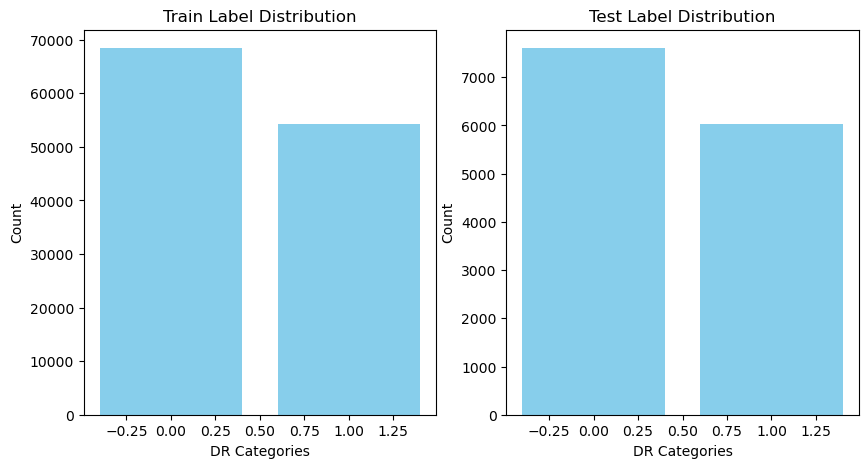

In [5]:
df = pd.read_csv(LABELS_PATH)
#df =df[::32]
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False, random_state=42)
df_val = df_test
#df =df.head(2500)

In [6]:
# Define the target image shape
SHAPE = (256, 256)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(90),  # Randomly rotate the image by up to 10 degrees
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip the image horizontally  
    transforms.GaussianBlur(kernel_size=5, sigma=(1.0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.1, saturation=0.0, hue=0.0),

])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
   # transforms.GaussianBlur(kernel_size=7, sigma=(2.0)),

])


if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

In [7]:
train_dataset = MultiViewMultiLabelMetaDataset(
    df_train, 
    IMG_COL_LIST, 
    IMAGES, 
    META_COL_LIST,
    LABEL_COL_LIST,  
    transform=train_transforms,
    meta_only=False,
    num_views_per_image=1
)

test_dataset = MultiViewMultiLabelMetaDataset(
    df_test, 
    
    IMG_COL_LIST, 
    IMAGES, 
    META_COL_LIST,
    LABEL_COL_LIST,  
    transform=test_transform,
    meta_only=False,
    num_views_per_image=1

)

val_dataset = MultiViewMultiLabelMetaDataset(
    df_val, 
    IMG_COL_LIST, 
    IMAGES, 
    META_COL_LIST,
    LABEL_COL_LIST,   
    transform=test_transform,
    meta_only=False,
    num_views_per_image=1

)
NUM_WORKERS=8
v = train_dataset[1]
       # plt.imshow(images[i].permute(1, 2, 0)) 

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True,persistent_workers =True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True,persistent_workers =True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True,persistent_workers =True)


In init
['Filename']
In init
['Filename']
In init
['Filename']


In [8]:
class ImageDecoder(nn.Module):
    def __init__(self, embedding_dim=512, output_channels=3, output_size=256):
        """
        Args:
            embedding_dim (int): Dimensionality of the input embedding (D).
            output_channels (int): Number of output channels (3 for RGB images).
            output_size (int): The height and width (H) of the output image (assumed square).
        """
        super(ImageDecoder, self).__init__()

        self.init_size = output_size // 16  # Smallest feature map size
        self.proj_channels = 512  # Initial feature map channels

        # 1x1 convolution to map (D,1,1) embedding to (proj_channels, 4, 4)
        self.conv1 = nn.ConvTranspose2d(embedding_dim, self.proj_channels, kernel_size=4, stride=1, padding=0)

        # Transposed convolutions for upsampling
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.proj_channels, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.Conv2d(256, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.Conv2d(128, 128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 16, kernel_size=1, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),

            nn.ConvTranspose2d(16, output_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Normalized output (-1 to 1)
        )

    def forward(self, x):
        """
        Forward pass of the decoder.
        
        Args:
            x (torch.Tensor): Input embedding of shape (N, D, 1, 1)
        
        Returns:
            torch.Tensor: Output image of shape (N, 3, H, H)
        """
        B = x.shape[0]  # Batch size

        # Reshape (B, D) → (B, D, 1, 1) before passing to convolution
        x = x.unsqueeze(-1).unsqueeze(-1)        
        x = self.conv1(x)  # Project embedding to feature map (N, 512, 4, 4)
        x = self.decoder(x)  # Upsample to full image size
        return x
        
class PreTrainModel(nn.Module):
    def __init__(self, backbone,num_metadata_features, embed_dim, num_patch, vision_emb_dim,num_labels,mask_fraction=0):
        super(PreTrainModel, self).__init__()
        self.backbone = backbone
        self.num_patch = num_patch
        self.vision_emb_dim = vision_emb_dim
        self.emb =nn.ModuleList([])
        self.num_metadata_features = num_metadata_features
        self.cls_emb  = torch.nn.Parameter(torch.randn(1, 1,embed_dim))
        #self.cls_emb.requires_grad_(False)  
        self.embed_dim = embed_dim
        self.mask_fraction = mask_fraction
        for i in range(num_metadata_features):
            self.emb.append(nn.Embedding(16, embed_dim))
        self.output_linear =nn.ModuleList([])
      #  self.output_encoder =nn.ModuleList([])
        for i in range(num_labels):
            self.output_linear.append(nn.Linear(embed_dim, 2))        
#        self.output_linear.append(nn.Linear(embed_dim, 4))

        self.dropout = nn.Dropout(mask_fraction)
        self.decoderdropout = nn.Dropout(mask_fraction)
        # For Convnextv2_base, 224,224
        self.backboneLinear = nn.Linear(self.vision_emb_dim,embed_dim) # 1024 for base, 768 for tiny
        # For Convnextv2_large, 224,224 
        #self.backboneLinear = nn.Linear(1536,embed_dim)
        # For Swin_small, 224,224
        #self.backboneLinear = nn.Linear(768,self.embed_dim)
        # For DinoV2_base
        #self.backboneLinear = nn.Linear(384,embed_dim)
        # For resnet
        #self.backboneLinear = nn.Linear(2048,self.embed_dim)
        self.decoder =ImageDecoder(embedding_dim=embed_dim, output_channels=3, output_size=256)
    
    def forward(self, x_list, x_meta):
        features=[]
        B = x_list[0].size()[0]
        for x in x_list: 
            z = self.backbone(x)  #downsampling included here
        


            
            z = self.dropout(z)
            z = self.backboneLinear(z)

            features.append(z)  # b x 1 x 512
            
        x = features[0]
        out = []
        for i in range(len(self.output_linear)):
            out.append(self.output_linear[i](x)) #         
        
        out_img = self.decoder(x)
        return out, out_img       
    

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)

model = PreTrainModel(
    backbone = backbone_model,
    num_metadata_features = len(LABEL_COL_LIST),
    embed_dim=EMBED_DIM,
    num_patch=1, 
    vision_emb_dim=512, #2048 (resnet50)
    num_labels = len(LABEL_COL_LIST),
    mask_fraction = 0.1
)





In [10]:
# Now make sure that loss can be calculated correctly
# Then change model to have multiple heads
criterion_list = []


for i in range(len(LABEL_COL_LIST)):
    
    class_indices = train_dataloader.dataset.df_labels.numpy()[:,i]
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32) 
    print(class_weights)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    criterion_list.append(criterion)

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
    

tensor([0.8967, 1.1303])
tensor([0.5292, 9.0744])


In [11]:
save_dir= 'C:\\Users\\preet\\Documents\\mBRSET\\mBRSET\\TEST\\pretrain_both_linear_r18_t1_mask10_new'

taskList = [0,1]

model = multitask_pretrain(model,taskList, train_dataloader, val_dataloader,test_dataloader,
              criterion_list, nn.L1Loss(),optimizer, scheduler=scheduler, num_epochs=50, save=True, save_dir = save_dir,device="cuda", 
              backbone=f'convnextv2_binary',patience=10) 

AMP True


  0%|                                                                                         | 0/3836 [00:08<?, ?it/s]


KeyboardInterrupt: 